# Libraries

In [66]:
import torch
import torch.nn as nn

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data preparation

We will be using Federal Reserve Economic Database (FRED) data concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325 records).

In [2]:
# Importing the data and using pandas datetime index feature
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)
df.sample(5)

,S4248SM144NCEN
DATE,
2002-07-01,6958
1993-06-01,4696
1995-09-01,4235
1997-11-01,4831
2011-01-01,6901


In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
print(df.shape)
df = df.dropna()
df.shape

(325, 1)


(325, 1)

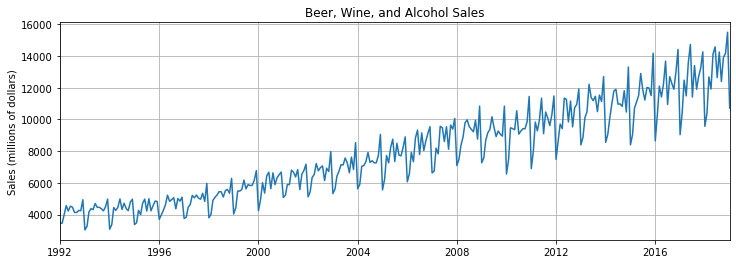

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df['S4248SM144NCEN'])
plt.grid()
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.autoscale(axis='x',tight=True) # Autoscale x grid around data

Data type has to be float.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   S4248SM144NCEN  325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [7]:
# Extract the values 
y = df['S4248SM144NCEN'].values.astype(float)

# Test size is one full cycle of the seasonality = 12 months
test_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

The data in this dataset ranges from thousands in the beginning to tens of thousands towards the end. Normalisation of the dataset will assist with the training and generalisation of the model. In this case we will be using SciKit learn's `MinMaxScaler`.

## Data scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler(feature_range=(-1,1))

When normalising the data, we will only use the min and max values of the training dataset to avoid data leakage. We need to fit the data, then transform it.

In [11]:
scaler.fit(train_set.reshape(-1,1))
train_norm = scaler.transform(train_set.reshape(-1,1))

## Prepare data for LSTM

Once the data has been normalised, it can be transformed to a tensor.

In [12]:
train_norm = torch.FloatTensor(train_norm).view(-1)

We create the windows for training.

In [13]:
def input_data(seq, ws, l=1):
    '''
    Creates the windows of data that willb e used for training.
    '''
    out = []
    for i in range(len(seq)-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+l]
        out.append((window,label))
    return out

In [14]:
window_size = 12
train_data = input_data(train_norm,window_size)
print(f'Expected values = {len(y)-len(test_set)-window_size}\tActual = {len(train_data)}')

Expected values = 301	Actual = 301


In [36]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

# Define model

In [28]:
class LSTMnetwork(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        # Add an LSTM layer
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully connected layer
        self.fc1 = nn.Linear(hidden_size,output_size)
        
        # Initialise h_0 and c_0
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred = self.fc1(lstm_out.view(len(seq),-1))
        return pred[-1]

## Define Loss and Optimiser

In [29]:
torch.manual_seed(101)

model = LSTMnetwork()

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.001)

In [30]:
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

# Training

In [31]:
epochs = 100

start_time = time.time()

for i in range(epochs):
    
    for seq, y_train in train_data:
        
        # Reset parameters and hidden states
        optimiser.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # Predict
        y_pred = model(seq)
        
        # Calculate loss and backpropagate
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimiser.step()
        
    print(f'Epoch {i+1:3}\tLoss: {loss:8.5f}')

        
total_time = time.time() - start_time
print(f'Completed in {total_time/60:.2f} mins')

Epoch   1	Loss:  0.25310
Epoch   2	Loss:  0.37532
Epoch   3	Loss:  0.39027
Epoch   4	Loss:  0.34935
Epoch   5	Loss:  0.33086
Epoch   6	Loss:  0.33230
Epoch   7	Loss:  0.32670
Epoch   8	Loss:  0.32074
Epoch   9	Loss:  0.30654
Epoch  10	Loss:  0.29518
Epoch  11	Loss:  0.26934
Epoch  12	Loss:  0.25999
Epoch  13	Loss:  0.24666
Epoch  14	Loss:  0.22404
Epoch  15	Loss:  0.18603
Epoch  16	Loss:  0.18561
Epoch  17	Loss:  0.17210
Epoch  18	Loss:  0.25164
Epoch  19	Loss:  0.22558
Epoch  20	Loss:  0.17456
Epoch  21	Loss:  0.20243
Epoch  22	Loss:  0.20799
Epoch  23	Loss:  0.16629
Epoch  24	Loss:  0.17633
Epoch  25	Loss:  0.11958
Epoch  26	Loss:  0.10084
Epoch  27	Loss:  0.04519
Epoch  28	Loss:  0.09457
Epoch  29	Loss:  0.00009
Epoch  30	Loss:  0.10171
Epoch  31	Loss:  0.00793
Epoch  32	Loss:  0.00039
Epoch  33	Loss:  0.02666
Epoch  34	Loss:  0.01991
Epoch  35	Loss:  0.03767
Epoch  36	Loss:  0.03401
Epoch  37	Loss:  0.03407
Epoch  38	Loss:  0.00003
Epoch  39	Loss:  0.00114
Epoch  40	Loss:  0.00004


# Model evaluation

In [34]:
future = 12

# Grab the last window of the training set to start predictions
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

When looking at the predictions, we can see they are normalised. To compare to the right values the normalisation needs to be inverted.

The `scaler` object created with the `MinMaxScaler` has an `inverse_transform` function.

In [38]:
true_preds = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
true_preds

array([[10342.98901096],
       [13371.71630904],
       [11057.17981285],
       [13735.24705338],
       [13838.95832589],
       [11777.73587801],
       [13776.42488337],
       [12052.86262867],
       [12935.27328959],
       [12598.74536121],
       [12609.34140733],
       [10369.80355194]])

We will compare the true values from the data to the predictions of our model

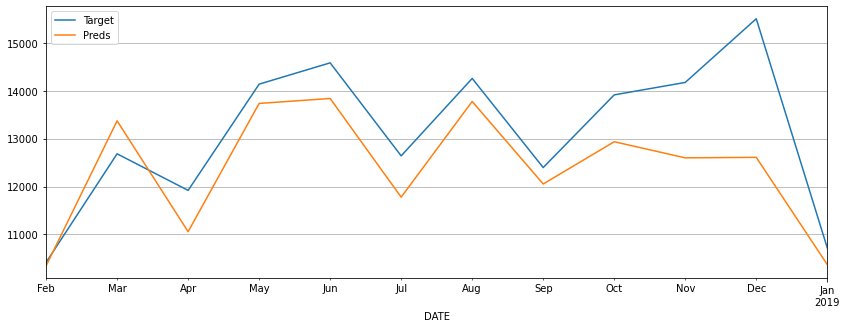

In [52]:
pd.DataFrame({'Target':df['S4248SM144NCEN'][-12:],'Preds':true_preds.reshape(-1)}).plot(figsize=(14,5))
plt.grid()

# Forecasting

To forecast first we will:
1. Normalise the entire dataset
2. Create windows for training
3. Train the model with the entirety of the data
4. Forecast new values
5. Invert the normalisation
6. Plot the results.

## Scaling the data

In [86]:
# Normalise the entire dataset and convert to a tensor
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(y.reshape(-1,1))
y_norm = scaler.transform(y.reshape(-1,1))

When converting to a tensor data has to be flattened

In [87]:
y_norm = torch.FloatTensor(y_norm).view(-1)
y_norm.shape

torch.Size([325])

## Creating training windows

In [88]:
# Create windows for all data
window_size = 12

all_data = input_data(y_norm,window_size)
print(f'Expected = {len(y)-12}\tActual = {len(all_data)}')

Expected = 313	Actual = 313


## Train the model

In [89]:
epochs = 100

model.train()

start_time = time.time()

for i in range(epochs):
    
    for seq, y in all_data:
        
        # Reset parameters and hidden states
        optimiser.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # Predict
        pred = model(seq)
        
        # Calculate loss and backpropagate
        loss = criterion(pred,y)
        loss.backward()
        optimiser.step()
        
    if i%10==0:
        print(f'Epoch {i+1:3}\tLoss: {loss:8.5f}')

        
total_time = time.time() - start_time
print(f'Completed in {total_time/60:.2f} mins')

Epoch   1	Loss:  0.01402
Epoch  11	Loss:  0.00683
Epoch  21	Loss:  0.00101
Epoch  31	Loss:  0.00073
Epoch  41	Loss:  0.00359
Epoch  51	Loss:  0.00017
Epoch  61	Loss:  0.00147
Epoch  71	Loss:  0.00770
Epoch  81	Loss:  0.00259
Epoch  91	Loss:  0.00107
Completed in 1.08 mins


## Forecast new values

In [171]:
window_size = 12
future = 12

# Grab the last window of the training set to start predictions
preds = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

## Invert normalisation

In [172]:
denorm_preds = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1,1))

## Plot result

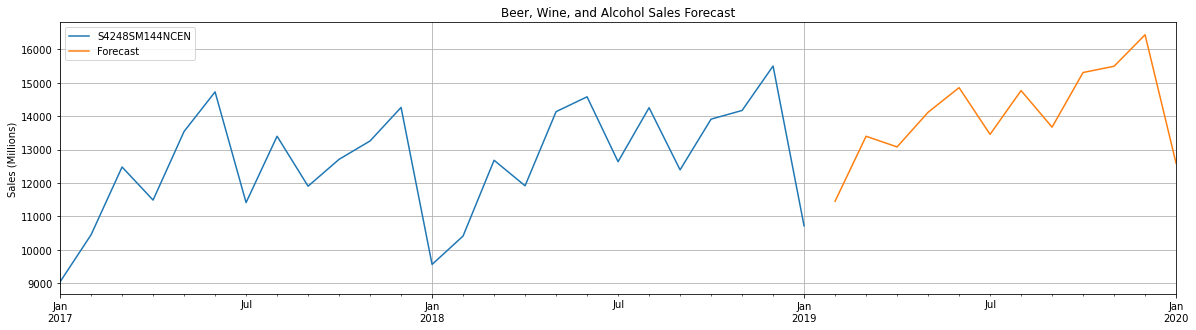

In [173]:
# Create datetime index for the new predictions

x = np.arange(start=df.iloc[-1].name+pd.DateOffset(months=1),stop=df.iloc[-1].name+pd.DateOffset(months=future+1),dtype='datetime64[M]').astype('datetime64[D]')
df['Type'] = 'Actual'
forecast_df = pd.concat([df,pd.DataFrame({'Forecast':denorm_preds.reshape(-1)}, index=x)])


# Plot results
forecast_df.loc['2017-01-01':].plot(figsize=(20,5),
                                    title='Beer, Wine, and Alcohol Sales Forecast',
                                    ylabel='Sales (Millions)')
plt.grid()